In [1]:
%load_ext rpy2.ipython

In [2]:
from IPython.display import FileLink

In [3]:
%%R
library(ggplot2)
library(plyr); library(dplyr); library(tidyr)
library(DESeq2)
library(phyloseq)
library(reshape)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, 

###This file is from the [sparsity notebook](./Sparsity_make_l2fc_table.ipynb).

In [4]:
%%R
FDR = 0.10

df.rspndrs = read.csv("data/l2fc_table2.csv") %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "both", ifelse(!is.na(x[1]), "Single Substrate", "Complex Substrate"))
}

df.rspndrs$rspnse = apply(df.rspndrs[,c("SS", "PS")], 1, rspnse)

df.rspndrs = df.rspndrs %>% select(OTU, rspnse)

df.rspndrs

Source: local data frame [39 x 2]

        OTU            rspnse
1  OTU.1023 Complex Substrate
2  OTU.1087 Complex Substrate
3   OTU.114  Single Substrate
4   OTU.119 Complex Substrate
5   OTU.120 Complex Substrate
6  OTU.1414  Single Substrate
7   OTU.169  Single Substrate
8    OTU.17  Single Substrate
9   OTU.185              both
10   OTU.19  Single Substrate
..      ...               ...


In [5]:
%%R
df_all = read.csv("data/l2fc_table2.csv")
head(df_all)

  sparsity_threshold Day Treatment     OTU log2FoldChange           p    Rank1
1               0.55  30        SS OTU.783     -0.3370825 0.996574093 Bacteria
2               0.55  30        SS  OTU.79      0.7598182 0.488986035 Bacteria
3               0.55  30        SS OTU.304      0.4183648 0.808983673 Bacteria
4               0.55  30        SS  OTU.50      0.7289694 0.525236764 Bacteria
5               0.55  30        SS OTU.382      2.9833574 0.000000137 Bacteria
6               0.55  30        SS OTU.465      0.5515994 0.688754034 Bacteria
          Rank2      Rank3        Rank4         Rank5       Rank6
1 Acidobacteria Holophagae      Sva0725          <NA>        <NA>
2 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
3 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
4 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
5 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
6 Bacteroidetes Cytophagia Cytophagales Cytophagace

In [6]:
%%R
#goal - dataframe with PS and SS l2fc values as columns in order to assign them at axis in the plot, 
#and to color the data points by response type 
# this is so I can do a linear regression analysis of just responders for this experiment
d = df_all %>% 
    select(OTU, Treatment, log2FoldChange, padj) %>% 
    spread(Treatment, log2FoldChange) %>%
    group_by(OTU)

d = left_join(d, df.rspndrs)

d = d[!is.na(d$rspnse),]

d2 = d[!is.na(d$PS),] 
d2 = d2 %>% 
    select(OTU, PS, rspnse) 
d3 = d[!is.na(d$SS),] 
d3 = d3 %>% 
    select(OTU, SS, rspnse) 
d = merge(d2, d3)
d

Joining by: "OTU"
        OTU            rspnse          PS        SS
1   OTU.114  Single Substrate  1.56975501 3.0088421
2  OTU.1414  Single Substrate -0.10699614 1.8688638
3    OTU.17  Single Substrate -0.07082457 1.7941707
4   OTU.185              both  2.45121472 3.2636744
5    OTU.19  Single Substrate  1.28225616 1.8565059
6   OTU.204 Complex Substrate  2.30654155 1.9207061
7   OTU.206  Single Substrate  0.12995008 2.3073683
8    OTU.20  Single Substrate -0.13466409 1.6616328
9  OTU.2192  Single Substrate  1.73786047 3.1206118
10 OTU.2294  Single Substrate  0.47090766 1.6549783
11  OTU.263  Single Substrate  0.47414143 1.7652442
12  OTU.266              both  2.16166561 3.1369309
13  OTU.285              both  1.90827498 2.5172257
14   OTU.38  Single Substrate -0.07511696 1.8219796
15 OTU.4322              both  2.47610483 2.2638251
16  OTU.442  Single Substrate  1.78824393 1.8548893
17  OTU.465 Complex Substrate  2.32116600 0.5515994
18  OTU.541              both  2.14910806 2.84

In [7]:
%%R
#goal - dataframe with PS and SS l2fc values as columns in order to assign them at axis in the plot, 
#and to color the data points by response type 
# this is so I can do a linear regression analysis of just responders for this experiment
d = df_all %>%
    select(OTU, Treatment, log2FoldChange) %>%
    spread(Treatment, log2FoldChange) 

d = left_join(df.rspndrs, d) %>% na.omit

d

Joining by: "OTU"
Source: local data frame [26 x 4]

        OTU            rspnse          PS       SS
1   OTU.114  Single Substrate  1.56975501 3.008842
2  OTU.1414  Single Substrate -0.10699614 1.868864
3    OTU.17  Single Substrate -0.07082457 1.794171
4   OTU.185              both  2.45121472 3.263674
5    OTU.19  Single Substrate  1.28225616 1.856506
6    OTU.20  Single Substrate -0.13466409 1.661633
7   OTU.204 Complex Substrate  2.30654155 1.920706
8   OTU.206  Single Substrate  0.12995008 2.307368
9  OTU.2192  Single Substrate  1.73786047 3.120612
10 OTU.2294  Single Substrate  0.47090766 1.654978
..      ...               ...         ...      ...


### The above dataframe does not include all responders detected in the single substrate study.   There are a total of 39 unique responders detected for this entire experiment. Not all are included in this dataframe because some responders have an "NA" value for l2fc in the treatment for which they were not detected.  Thus, this df (and analysis) does not include 13 of the responders detected.

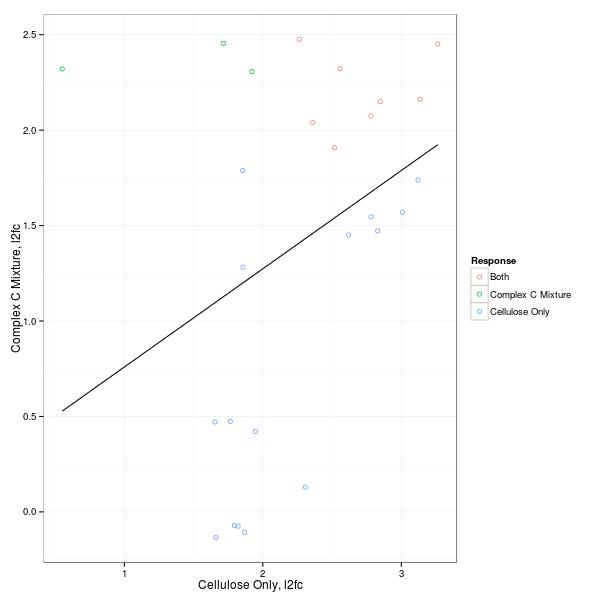

In [8]:
%%R -h 600 -w 600

colours = c("red", "#377eb8", "#4daf4a")

p = ggplot(d, aes(y = PS, x = SS, color = factor(rspnse, labels = c("Both", "Complex C Mixture", "Cellulose Only"))))

p = p + geom_point(shape = 21)

p = p + stat_smooth(method = "lm", aes(group = 1), se = FALSE, color = "black")

p = p + labs(x = "Cellulose Only, l2fc",
            y = "Complex C Mixture, l2fc", 
            color = "Response")

p = p + theme_bw()

p

In [9]:
%%R
fit = lm(PS ~ SS, d)
summary(fit)


Call:
lm(formula = PS ~ SS, data = d)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.31317 -0.66532 -0.01508  0.56687  1.79300 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.2443     0.6662   0.367   0.7171  
SS            0.5147     0.2842   1.811   0.0826 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8929 on 24 degrees of freedom
Multiple R-squared:  0.1203,	Adjusted R-squared:  0.0836 
F-statistic: 3.281 on 1 and 24 DF,  p-value: 0.08264



In [10]:
%%R
ggsave("figs/linreg_only_respdrs.pdf", p, h = 10, w = 8)

In [11]:
FileLink("figs/linreg_only_respdrs.pdf")

/home/ashley/single_substrate/figs/linreg_only_respdrs.pdf

In [12]:
%%R
ggsave("figs/linreg_only_respdrs.png", p, h = 10, w = 8)

In [13]:
FileLink("figs/linreg_only_respdrs.png")

/home/ashley/single_substrate/figs/linreg_only_respdrs.png

In [14]:
%%R
df_shared_resp = subset(d, (rspnse == "both"))
nrow (df_shared_resp)

[1] 8


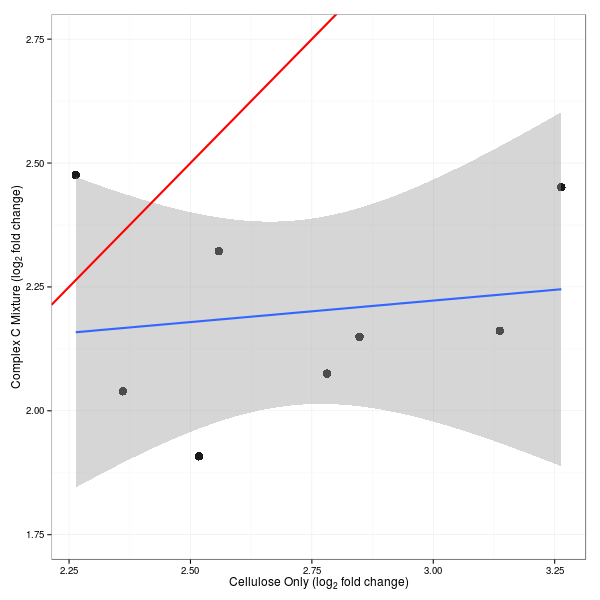

In [37]:
%%R -h 600 -w 600

p2 = ggplot(df_shared_resp, aes(y = PS, x = SS))

p2 = p2 + geom_point(alpha = 0.9, size = 4, color = "black")

#p = p + geom_abline(aes(intercept=0.2443, slope=0.5147), data=d)

p2 = p2 + stat_smooth(method = "lm", aes(group = 1), size = 1)

p2 = p2 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Complex C Mixture (", log[2]," fold change)",sep=""))
              )

p2 = p2 + theme_bw()
p2 = p2 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p2 = p2 + scale_y_continuous(limit = c(1.75, 2.75), breaks = c(1.75, 2, 2.25, 2.5,
                                                           2.75))
#p2 = p2 + annotate("text", x=2.75, y=2.55, label = "R^{2}==0", hjust=1, size=5.75, family="Times", parse=TRUE)

p2

In [16]:
%%R
fit = lm(PS ~ SS, df_shared_resp)
summary(fit)


Call:
lm(formula = PS ~ SS, data = df_shared_resp)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27235 -0.12779 -0.06648  0.15494  0.31747 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.96221    0.62311   3.149   0.0198 *
SS           0.08677    0.22769   0.381   0.7163  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2153 on 6 degrees of freedom
Multiple R-squared:  0.02363,	Adjusted R-squared:  -0.1391 
F-statistic: 0.1452 on 1 and 6 DF,  p-value: 0.7163



In [38]:
%%R
ggsave("figs/linreg_shared_respdrs.pdf", p2, h = 10, w = 8)

In [39]:
%%R
ggsave("figs/linreg_shared_respdrs.png", p2)

Saving 6.67 x 6.67 in image


In [40]:
FileLink("figs/linreg_shared_respdrs.pdf")

/home/ashley/single_substrate/figs/linreg_shared_respdrs.pdf

In [41]:
FileLink("figs/linreg_shared_respdrs.png")

/home/ashley/single_substrate/figs/linreg_shared_respdrs.png